In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression,kalman_filter, make_FXHedge
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Load Data

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

#fx
EUR_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']
GBP_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['GBP/USD']

In [6]:
guru_er = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True, \
                   dayfirst=True)[['EU_BNPILSNE']]

guru_fx_er = make_FXHedge(guru_er,EUR_USD_fx)

In [11]:
bnp_all_EU = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True,\
                      dayfirst=True)[["EU_BNPIPMEE","EU_BNPIPVEE","EU_BNPIPQEE","EU_BNPIPLEE"]]

bnp_all_US = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0,parse_dates=True,\
                      dayfirst=True)[["US_BNPIPMUE","US_BNPIPVUE","US_BNPIPQUE","US_BNPIPLUE"]]

bnp_all_fx_EU = make_FXHedge(bnp_all_EU,EUR_USD_fx)

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFGB',
                                                                                                 "BNPIFCH","BNPIFUS",
                                                                                                 "BNPIFUSC"]]
bnp = bnp.join(bnp_all_fx_EU,how="inner").join(bnp_all_US,how="inner")
bnp = bnp/bnp.iloc[0]
bnp.head()

,BNPIFEU,BNPIFGB,BNPIFCH,BNPIFUS,BNPIFUSC,EU_BNPIPMEE,EU_BNPIPVEE,EU_BNPIPQEE,EU_BNPIPLEE,US_BNPIPMUE,US_BNPIPVUE,US_BNPIPQUE,US_BNPIPLUE
2003-12-31,1,1,1,1,1,1,1,1,1,1,1,1,1
2004-01-01,1,1,1,1,1,0.999504,0.999306,0.999306,0.999405,1,1,1,1
2004-01-02,1.01435,1.00926,1,0.999,1.00705,1.00273,1.00223,0.99971,1.00486,0.998294,1.0021,0.997998,0.996399
2004-01-05,1.01671,1.00758,1.01735,1.01137,1.02148,1.00364,1.00586,0.999609,1.00878,0.997992,1.0028,1.0018,0.9989
2004-01-06,1.01688,1.00655,1.0199,1.01331,1.02318,1.00273,1.00102,0.995278,1.00667,1.00141,1.0048,1.0025,0.996899


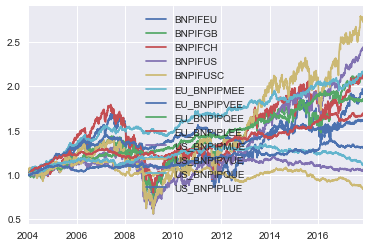

In [12]:
bnp.plot()

In [13]:
prices_all = bnp.ffill().dropna()
returns_all = prices_all.resample('1D').first().pct_change().dropna()
guru_returns = guru_fx_er.resample('1D').first().pct_change().dropna()

In [14]:
returns_all.head()

,BNPIFEU,BNPIFGB,BNPIFCH,BNPIFUS,BNPIFUSC,EU_BNPIPMEE,EU_BNPIPVEE,EU_BNPIPQEE,EU_BNPIPLEE,US_BNPIPMUE,US_BNPIPVUE,US_BNPIPQUE,US_BNPIPLUE
2004-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000496,-0.000694,-0.000694,-0.000595,0.000000,0.000000,0.000000,0.000000
2004-01-02,0.014352,0.009257,0.000000,-0.001000,0.007049,0.003232,0.002930,0.000404,0.005455,-0.001706,0.002101,-0.002002,-0.003601
2004-01-05,0.002323,-0.001662,0.017346,0.012381,0.014334,0.000903,0.003614,-0.000101,0.003905,-0.000302,0.000699,0.003812,0.002510
2004-01-06,0.000169,-0.001026,0.002514,0.001924,0.001663,-0.000903,-0.004807,-0.004333,-0.002097,0.003420,0.001996,0.000700,-0.002003
2004-01-07,-0.008817,-0.006311,-0.002333,0.002560,0.008317,0.001285,0.006335,0.000299,0.000788,-0.000702,-0.001295,-0.003396,-0.003612


In [15]:
size = 60
freq = 5

df_weight_ols = ols_regression(guru_returns, returns_all, size, freq)

prices_for_track_ols = prices_all.loc[df_weight_ols.index[0]:]
replication_ols = make_track(prices_for_track_ols, df_weight_ols)

df_res = guru_fx_er.loc[replication_ols.index]
df_res["OLS all"] = replication_ols

In [16]:
%%time
for nu in [2,4,6,8]:
    df_weight_kalman = kalman_filter(guru_returns, returns_all,freq, sigma_weight=nu*0.1 , sigma_return=0.1)\
                    .loc[df_weight_ols.index[0]:]

    prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]
    replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
    df_res["Kalman {}".format(nu)] = replication_kalman

CPU times: user 19.8 s, sys: 207 ms, total: 20 s
Wall time: 21.4 s


In [17]:
df_res = df_res/df_res.iloc[0]

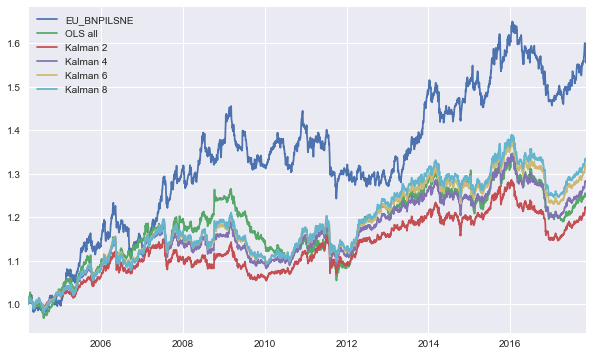

In [18]:
df_res.plot(figsize=(10,6))

In [20]:
Returns = df_res.pct_change().dropna()
Returns_repl = Returns.drop("EU_BNPILSNE", axis=1)
Returns_guru = Returns["EU_BNPILSNE"]

df_correl = Returns.corr(method='pearson')
df_correl

,EU_BNPILSNE,OLS all,Kalman 2,Kalman 4,Kalman 6,Kalman 8
EU_BNPILSNE,1.000000,0.545703,0.578729,0.603581,0.608899,0.608306
OLS all,0.545703,1.000000,0.812941,0.856428,0.876482,0.887976
Kalman 2,0.578729,0.812941,1.000000,0.979087,0.952426,0.929271
Kalman 4,0.603581,0.856428,0.979087,1.000000,0.993321,0.980935
Kalman 6,0.608899,0.876482,0.952426,0.993321,1.000000,0.996565
Kalman 8,0.608306,0.887976,0.929271,0.980935,0.996565,1.000000


In [23]:
df_stats = pd.DataFrame(index=df_res.drop("EU_BNPILSNE",axis=1).columns)
df_stats["correl"] = df_correl.loc["EU_BNPILSNE"].drop("EU_BNPILSNE")
df_stats["TE"] = (Returns_repl.T - Returns_guru.values).std(axis=1)
df_stats['$R^2$'] = 1 - (Returns_repl.T - Returns_guru.values).var(axis=1) / Returns_guru.values.var()

df_stats

,correl,TE,$R^2$
OLS all,0.545703,0.003329,0.213544
Kalman 2,0.578729,0.003066,0.333016
Kalman 4,0.603581,0.003008,0.357845
Kalman 6,0.608899,0.003003,0.360001
Kalman 8,0.608306,0.003016,0.354540


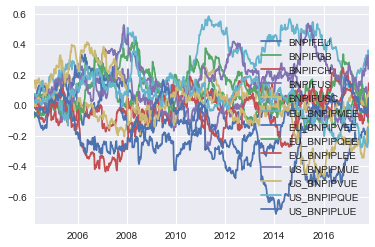

In [22]:
df_weight_kalman.plot()